In [1]:
import torch
import torchvision
import tarfile
from torch import nn, optim
from torch.autograd import Variable

import numpy as np
import math

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
path = 'fer2013.csv'

data_df = pd.read_csv(path)
data_df.head(4)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training


In [3]:
print('samples:', len(data_df))

print(data_df['Usage'].nunique())
print(data_df['Usage'].unique())

samples: 35887
3
['Training' 'PublicTest' 'PrivateTest']


In [4]:
trainData = data_df[data_df['Usage'] == 'Training']
testData = data_df[data_df['Usage'] != 'Training']
print(f'training samples:{len(trainData)}\n testing samples:{len(testData)}')

training samples:28709
 testing samples:7178


In [5]:
labels = {
    0:'Angry',
    1:'Disgust',
    2:'Fear',
    3:'Happy',
    4:'Sad',
    5:'Surprise',
    6:'Neutral'
}
print(labels)

{0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}


In [6]:
# creating tensors from input pixels
tensorData = torch.as_tensor([[float(i) for i in trainData['pixels'][j].split(' ')] for j in range(len(trainData))])

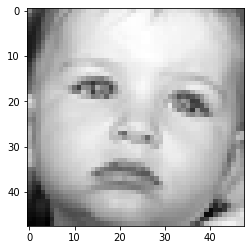

In [7]:
plt.imshow(tensorData[1500].reshape([48, 48]), cmap='gray')

(array([[99.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [10., 10., 10., 10., 11.,  9., 10., 10., 10., 11.]]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ], dtype=float32),
 <a list of 2 BarContainer objects>)

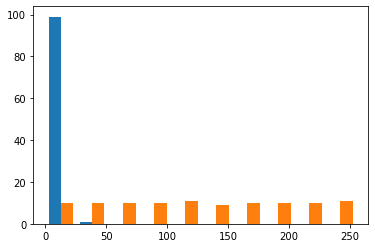

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

hist = tensorData[:500, 3].histogram()

plt.hist(hist)

In [10]:
Ns = tensorData.size()[0]
Ni = tensorData.size()[1]
No = len(labels)
a = 2

Neurons = Ns // (a * (Ni + No))

print(Neurons)

6


In [11]:
# getting labels
y = torch.tensor(trainData['emotion'].values)

In [13]:
# transforming single column labels into a 7 element vector for each example
zs = torch.zeros(tensorData.shape[0], 7)

for i in range(zs.shape[0]):
    for j in range(zs.shape[1]):
        if y[i] == j:
            zs[i][j] = 1

In [14]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [72]:
X_train, y_train = tensorData.reshape(F.normalize(tensorData).shape[0], 1, 48, 48), y



X_test = torch.as_tensor([[float(i) for i in testData['pixels'][j].split(' ')] for j in testData.index])

X_test = F.normalize(X_test)

X_test = X_test.reshape(X_test.shape[0], 1, 48, 48)

y_test = torch.tensor(testData['emotion'].values)

In [112]:
# Convolutional Neural Net
import torch.nn as nn
import torch.nn.functional as F
class CNN(nn.Module):
    def __init__(self, n_hid=8, epochs=3, eta=0.05, mB=1000):
        super(CNN, self).__init__()
        self.n_hid, self.epochs, self.eta, self.mB = n_hid, epochs, eta, mB
        
        self.optimizer = None
        self.loss_func = nn.CrossEntropyLoss()#
        
        self.net = nn.Sequential(
            nn.Conv2d(1, self.n_hid, self.n_hid),
            nn.BatchNorm2d(self.n_hid),
            nn.ReLU(),
            #nn.MaxPool2d(2),

            nn.Conv2d(self.n_hid, self.n_hid*2, Neurons),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(start_dim=1),
            
            # 9*9 is computed in the above cell - based on 48x48 image size
            nn.Linear(self.n_hid*338, 128),  # 256 arbitrary
            nn.BatchNorm1d(128),
            #nn.LayerNorm(128),
            
            nn.Linear(128, 7),
        )

    def _forward(self, _X, apply_softmax=False):
        import torch.nn.functional as F
        out = self.net(_X)
        if apply_softmax:
            out = F.softmax(out, dim=1)
        return out

    def _reset(self):
        for m in self.modules():
            if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
                 m.reset_parameters()

    def predict(self, _X):
        net_out = self._forward(_X, apply_softmax=True)
        p_values, indices = net_out.max(dim=1)
        return indices

    def fit(self, _X, _y):
        import torch.optim as optim
        self._reset()  # Reset the neural network weights
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.eta)
        for _ in range(self.epochs):
            indices = np.arange(_X.shape[0])
            for ix in range(0, indices.shape[0]-self.mB+1, self.mB):
                ixB = indices[ix:ix+self.mB]
                self.optimizer.zero_grad()
                net_out = self._forward(_X[ixB])
                
                loss = self.loss_func(net_out, _y[ixB])
                loss.backward()
                self.optimizer.step()

In [113]:
cnn = CNN(Neurons*3, 10, 0.001, 3000)
cnn.fit(X_train, zs)

In [114]:
y_pred = cnn.predict(X_train)
train_acc = (torch.sum(y_train==y_pred).float() / X_train.shape[0])

print(f"MLP training accuracy= {train_acc:.3f}")

MLP training accuracy= 0.583


In [115]:
y_predT = cnn.predict(X_test)
test_acc = (torch.sum(y_test==y_predT).float() / X_test.shape[0])

print(f"MLP new data accuracy= {test_acc:.3f}")

MLP new data accuracy= 0.451
